In [1]:
import nilearn
from nilearn import plotting, masking
from nilearn import datasets, image
from nilearn.maskers import NiftiLabelsMasker
import seaborn as sns
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import zipfile, os, multiprocessing, itertools
import scipy.stats as stat
from sklearn.metrics import DistanceMetric
import read_file_utils

In [2]:
glm_output_dir = "glm_outputs/wait_contrasts"
sub_list = np.array([str(i).zfill(2) for i in np.delete(np.arange(1, 27), [9, 20, 24])])
runs = np.array([str(i).zfill(2) for i in np.arange(1, 11)])
tasks = np.tile(['straight', 'rotate'], 5)

In [3]:
# sub_list

# Atlases and ROI masks

In [4]:
dataset_juelich = datasets.fetch_atlas_juelich("maxprob-thr25-2mm")
masks = {"premotor":"GM Premotor cortex BA6", 
         "motor": "GM Primary motor cortex BA4a",
         "v1": "GM Visual cortex V1 BA17",
         "sup_parietal": "GM Superior parietal lobule 7P",
         "inf_parietal": "GM Inferior parietal lobule PF",
         "somatosensory": "GM Primary somatosensory cortex BA1"
        }
masks = {
         "motor": "GM Primary motor cortex BA4a",
         "v1": "GM Visual cortex V1 BA17",
         "sup_parietal": "GM Superior parietal lobule 7P",
                 }

# dataset_msdl = datasets.fetch_atlas_msdl()
# masks = {"motor": "Motor", 
#          "parietal": "L Par",
#          "vis": "Vis",
#          "cerebellum": "Cereb"       
#         }
# atlas_filename = dataset_ho['maps']

# Function to extract ROI fMRI stignals in an array
1. Path: Path of the stat map nii.gz file
2. Conditions: condition label appended to the path based on event stat map
3. Region: Specifies ROI mask (region to atlas label map from atlas above)
4. dataset_juelich: Juelich dataset

In [5]:
def extract_roi_signals_juelich(path, conditions, region, masks=masks, dataset_juelich=dataset_juelich):
    #determine mask image from juelich atlas
    mask_image = image.new_img_like(dataset_juelich.maps, image.get_data(dataset_juelich.maps) == np.where(np.array(dataset_juelich.labels) == masks[region])[0][0])
    # print(conditions)
    #Apply the mask to data for all (33) conditions where each condition corresponds to stat map (output of fsl feat)
    fmri_masked = [
        masking.apply_mask(image.load_img(path+f'/{condition}.nii.gz'), 
        mask_img = image.resample_to_img(mask_image, image.load_img(path+f'/{condition}.nii.gz'), 
        interpolation='nearest')
        )
        for condition in conditions  
    ]
    return fmri_masked

Extract all paths for straight and rotated blocks. 

Extracting for 23 participnats because the 24th participant seems to not have one rotated block

In [6]:
sub_straight_paths = np.ravel([[
        f'{glm_output_dir}/sub-{sub}/run-{run}_{tasks[i]}' 
        for i, run in enumerate(runs) if tasks[i] == 'straight'
    ] for sub in sub_list
])

sub_rotate_paths = np.ravel([[
        f'{glm_output_dir}/sub-{sub}/run-{run}_{tasks[i]}' 
        for i, run in enumerate(runs) if tasks[i] == 'rotate'
    ] for sub in sub_list
])

In [7]:
conditions = [i[:-7].decode("utf-8") for i in os.listdir(sub_rotate_paths[0])]
# conditions

# Compute correlations for all subjects
1. paths: image paths extracted above
2. region: ROI region from juelich atlas (through masks map above)
3. nsub: 23 subjects

In [8]:
def extract_corr_all_sub(paths, region = 'motor', nsub = 23):
    #parallelize extracting roi signals. This is the main bottleneck in computation since it requires reading and writing
    pool = multiprocessing.Pool()
    # print(paths)
    signal_all_sub = []
    # for path in paths:
    #     conditions = os.listdir(path)
    #     for mask in masks:
    #         signal_all_sub.append(extract_roi_signals_juelich(path, event_cope_map.keys(), region))
    signal_all_sub = pool.starmap(
            extract_roi_signals_juelich,
            zip(paths, 
            itertools.repeat(conditions), 
            # itertools.repeat(list(event_cope_map.keys())), 
            itertools.repeat(region), 
            itertools.repeat(masks), 
            itertools.repeat(dataset_juelich)
            )
        )

    #compute correlations for each subject between conditions. 
    #[1::2] allows for alternating conditions so that we get correlations of beta weights from actual events and not their derivatives. 
    #Skipping the first one (as [1::2]) skips the 'wait' periods
    #Uncomment if using pes and not copes
    corr_maps = np.array([
            [
                [
                    stat.pearsonr(x, y)[0] for x in signal_all_sub[sub_block]#[1::2] 
                ]
            for y in signal_all_sub[sub_block]#[1::2]
            ]
        for sub_block in range(len(signal_all_sub))
    ])

    # print(corr_maps)
    # print(signal_all_sub.shape)
    return corr_maps.reshape(nsub, 5, corr_maps.shape[1], corr_maps.shape[2])


In [9]:
# 30345//(85*17)

In [10]:
#Extract correlations for all subjects in dictionaries

straight_corr_dict = {}
for key in masks.keys():
    straight_corr_dict[key] = extract_corr_all_sub(sub_straight_paths, region=key, nsub=len(sub_list))
    print('Mask done: ', key)

rotate_corr_dict = {}
for key in masks.keys():
    rotate_corr_dict[key] = extract_corr_all_sub(sub_rotate_paths, region=key, nsub=len(sub_list))
    print('Mask done: ', key)

Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal


In [11]:
def extract_corr_crosscond_all_sub(straight_paths, rotated_paths, region = 'motor', nsub = 23):
    #parallelize extracting roi signals. This is the main bottleneck in computation since it requires reading and writing
    pool = multiprocessing.Pool()
    straight_signal_all_sub = pool.starmap(
            extract_roi_signals_juelich,
            zip(straight_paths, 
            # itertools.repeat(list(event_cope_map.keys())), 
            itertools.repeat(conditions), 
            itertools.repeat(region), 
            itertools.repeat(masks), 
            itertools.repeat(dataset_juelich)
            )
        )
    print('here')
    rotated_signal_all_sub = pool.starmap(
            extract_roi_signals_juelich,
            zip(rotated_paths, 
            itertools.repeat(conditions), 
            # itertools.repeat(list(event_cope_map.keys())), 
            itertools.repeat(region), 
            itertools.repeat(masks), 
            itertools.repeat(dataset_juelich)
            )
        )

    #compute correlations for each subject between conditions. 
    #[1::2] allows for alternating conditions so that we get correlations of beta weights from actual events and not their derivatives. 
    #Skipping the first one (as [1::2]) skips the 'wait' periods
    #Above should be uncommented when using pes and not copes
    corr_maps = np.array([
            [
                [
                    stat.pearsonr(x, y)[0] for x in straight_signal_all_sub[sub_block]#[1::2] 
                ]
            for y in rotated_signal_all_sub[sub_block]#[1::2]
            ]
        for sub_block in range(len(straight_signal_all_sub))
    ])


    # print(signal_all_sub.shape)
    return corr_maps.reshape(nsub, 5, corr_maps.shape[1], corr_maps.shape[2])


In [12]:
#Extract correlations for all subjects in dictionaries

cross_corr_dict = {}
for key in masks.keys():
    cross_corr_dict[key] = extract_corr_crosscond_all_sub(sub_straight_paths, sub_rotate_paths, region=key, nsub=len(sub_list))
    print('Mask done: ', key)

# rotate_corr_dict = {}
# for key in masks.keys():
#     rotate_corr_dict[key] = extract_corr_all_sub(sub_rotate_paths, region=key)
#     print('Mask done: ', key)

here
Mask done:  motor
here
Mask done:  v1
here
Mask done:  sup_parietal


In [13]:
# cross_corr_dict['motor'].shape

In [14]:
#Dictionaries to dataframes for easy plotting and stats
nsub = len(sub_list)
temp_df = []
for region in masks.keys():
    ss_corr_df = pd.DataFrame({
        'subject': np.repeat(np.arange(nsub), 5*len(conditions)*len(conditions)),
        'block': np.tile(np.repeat(np.arange(5), len(conditions)*len(conditions)), nsub),
        'cond 1': np.tile(np.repeat(conditions, len(conditions)), 5*nsub),
        'cond 2': np.tile(conditions, len(conditions)*5*nsub),
        'correlations': np.ravel(straight_corr_dict[region])
    })
    ss_corr_df['region'] = region
    ss_corr_df['type'] = 'straight-straight'
    temp_df.append(ss_corr_df)
ss_corr_df = pd.concat(temp_df).reset_index(drop=True)

temp_df = []
for region in masks.keys():
    rr_corr_df = pd.DataFrame({
        'subject': np.repeat(np.arange(nsub), 5*len(conditions)*len(conditions)),
        'block': np.tile(np.repeat(np.arange(5), len(conditions)*len(conditions)), nsub),
        'cond 1': np.tile(np.repeat(conditions, len(conditions)), 5*nsub),
        'cond 2': np.tile(conditions, len(conditions)*5*nsub),
        'correlations': np.ravel(rotate_corr_dict[region])
    })
    rr_corr_df['region'] = region
    rr_corr_df['type'] = 'rotate-rotate'
    temp_df.append(rr_corr_df)
rr_corr_df = pd.concat(temp_df).reset_index(drop=True)
    
temp_df = []
for region in masks.keys():
    corr_df_cross = pd.DataFrame({
        'subject': np.repeat(np.arange(nsub), 5*len(conditions)*len(conditions)),
        'block': np.tile(np.repeat(np.arange(5), len(conditions)*len(conditions)), nsub),
        'cond 1': np.tile(np.repeat(conditions, len(conditions)), 5*nsub),
        'cond 2': np.tile(conditions, len(conditions)*5*nsub),
        'correlations': np.ravel(cross_corr_dict[region])
    })
    corr_df_cross['region'] = region
    corr_df_cross['type'] = 'straight-rotate'
    temp_df.append(corr_df_cross)
    # temp_df.append(corr_df_cross)
sr_corr_df = pd.concat(temp_df).reset_index(drop=True)


corr_df = pd.concat([ss_corr_df, rr_corr_df, sr_corr_df]).reset_index(drop=True)

In [45]:
corr_df.to_csv('mvpa_outputs/event_correlations.csv')

In [15]:
corr_df

,subject,block,cond 1,cond 2,correlations,region,type
0,0,0,go_153_prep,go_153_prep,1.000000,motor,straight-straight
1,0,0,go_153_prep,go_207_prep,0.112862,motor,straight-straight
2,0,0,go_153_prep,go_45_prep,0.097505,motor,straight-straight
3,0,0,go_153_prep,go_99_prep,-0.131254,motor,straight-straight
4,0,0,go_153_prep,movement_153,-0.686290,motor,straight-straight
...,...,...,...,...,...,...,...
264955,22,4,non_movement_99,nogo_99_prep,0.140207,sup_parietal,straight-rotate
264956,22,4,non_movement_99,non_movement_153,-0.095407,sup_parietal,straight-rotate
264957,22,4,non_movement_99,non_movement_207,0.049228,sup_parietal,straight-rotate
264958,22,4,non_movement_99,non_movement_45,0.154805,sup_parietal,straight-rotate


In [14]:
#Dictionaries to dataframes for easy plotting and stats

temp_df = []
for region in masks.keys():
    corr_df_cross = pd.DataFrame({
        'subject': np.repeat(np.arange(23), 5*16*16),
        'block': np.tile(np.repeat(np.arange(5), 16*16), 23),
        'cond 1': np.tile(np.repeat(list(cope_event_map.keys()), 16), 5*23),
        'cond 2': np.tile(list(cope_event_map.keys()), 16*5*23),
        'correlations': np.ravel(cross_corr_dict[region])
    })
    corr_df_cross['region'] = region
    temp_df.append(corr_df_cross)


corr_df_cross = pd.concat(temp_df)

In [12]:
corr_df_cross.to_csv('mvpa_outputs/event_correlations_.csv')

Plotting

Text(0.5, 0.98, 'Figure 1A')

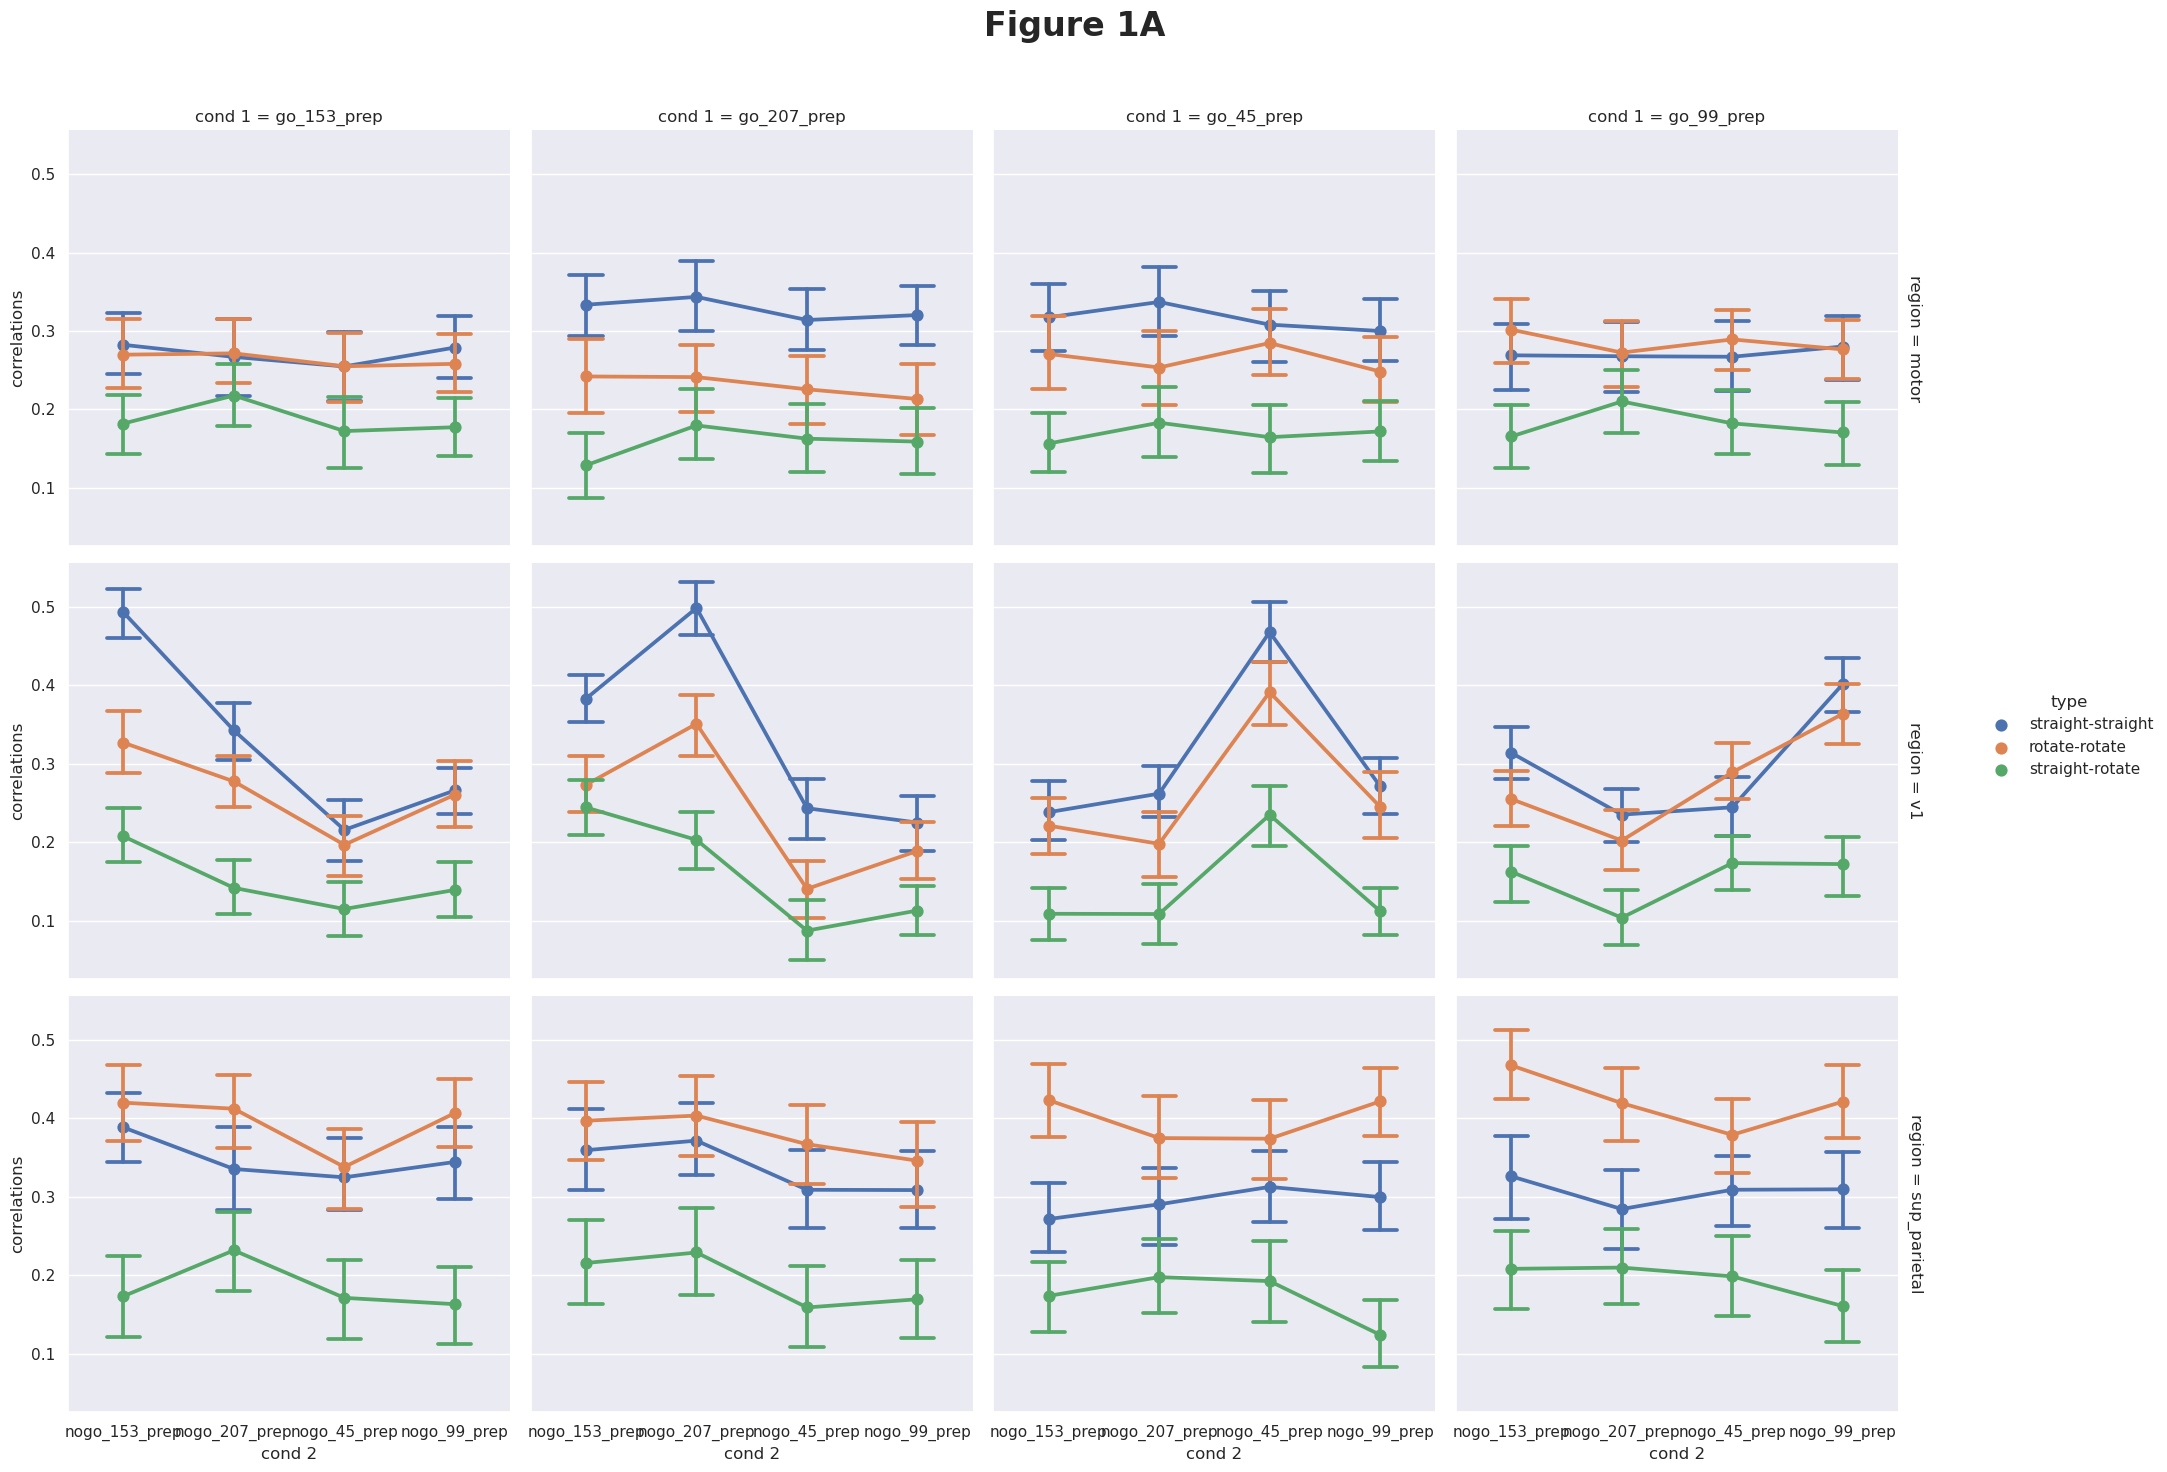

In [49]:
sns.set_context('poster') #Better font sizes
sns.set_theme()
g = sns.catplot(
    col = 'cond 1', x = 'cond 2', y = 'correlations', row = 'region',
    kind = 'point', capsize = 0.3, margin_titles = True, hue = 'type',
    data = corr_df.loc[((corr_df['cond 1'].str.contains('prep')) & (corr_df['cond 2'].str.contains('prep')) &
    (corr_df['cond 1'].str.startswith('go')) & (corr_df['cond 2'].str.startswith('nogo')))],
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Figure 1A', fontsize = 24, fontweight = 'heavy')
# g.set_xticklabels(g.get_xticklabels(), rotation=45)

# plt.savefig('mvpa_outputs/plots/nogo_correlations.png', dpi = 600)

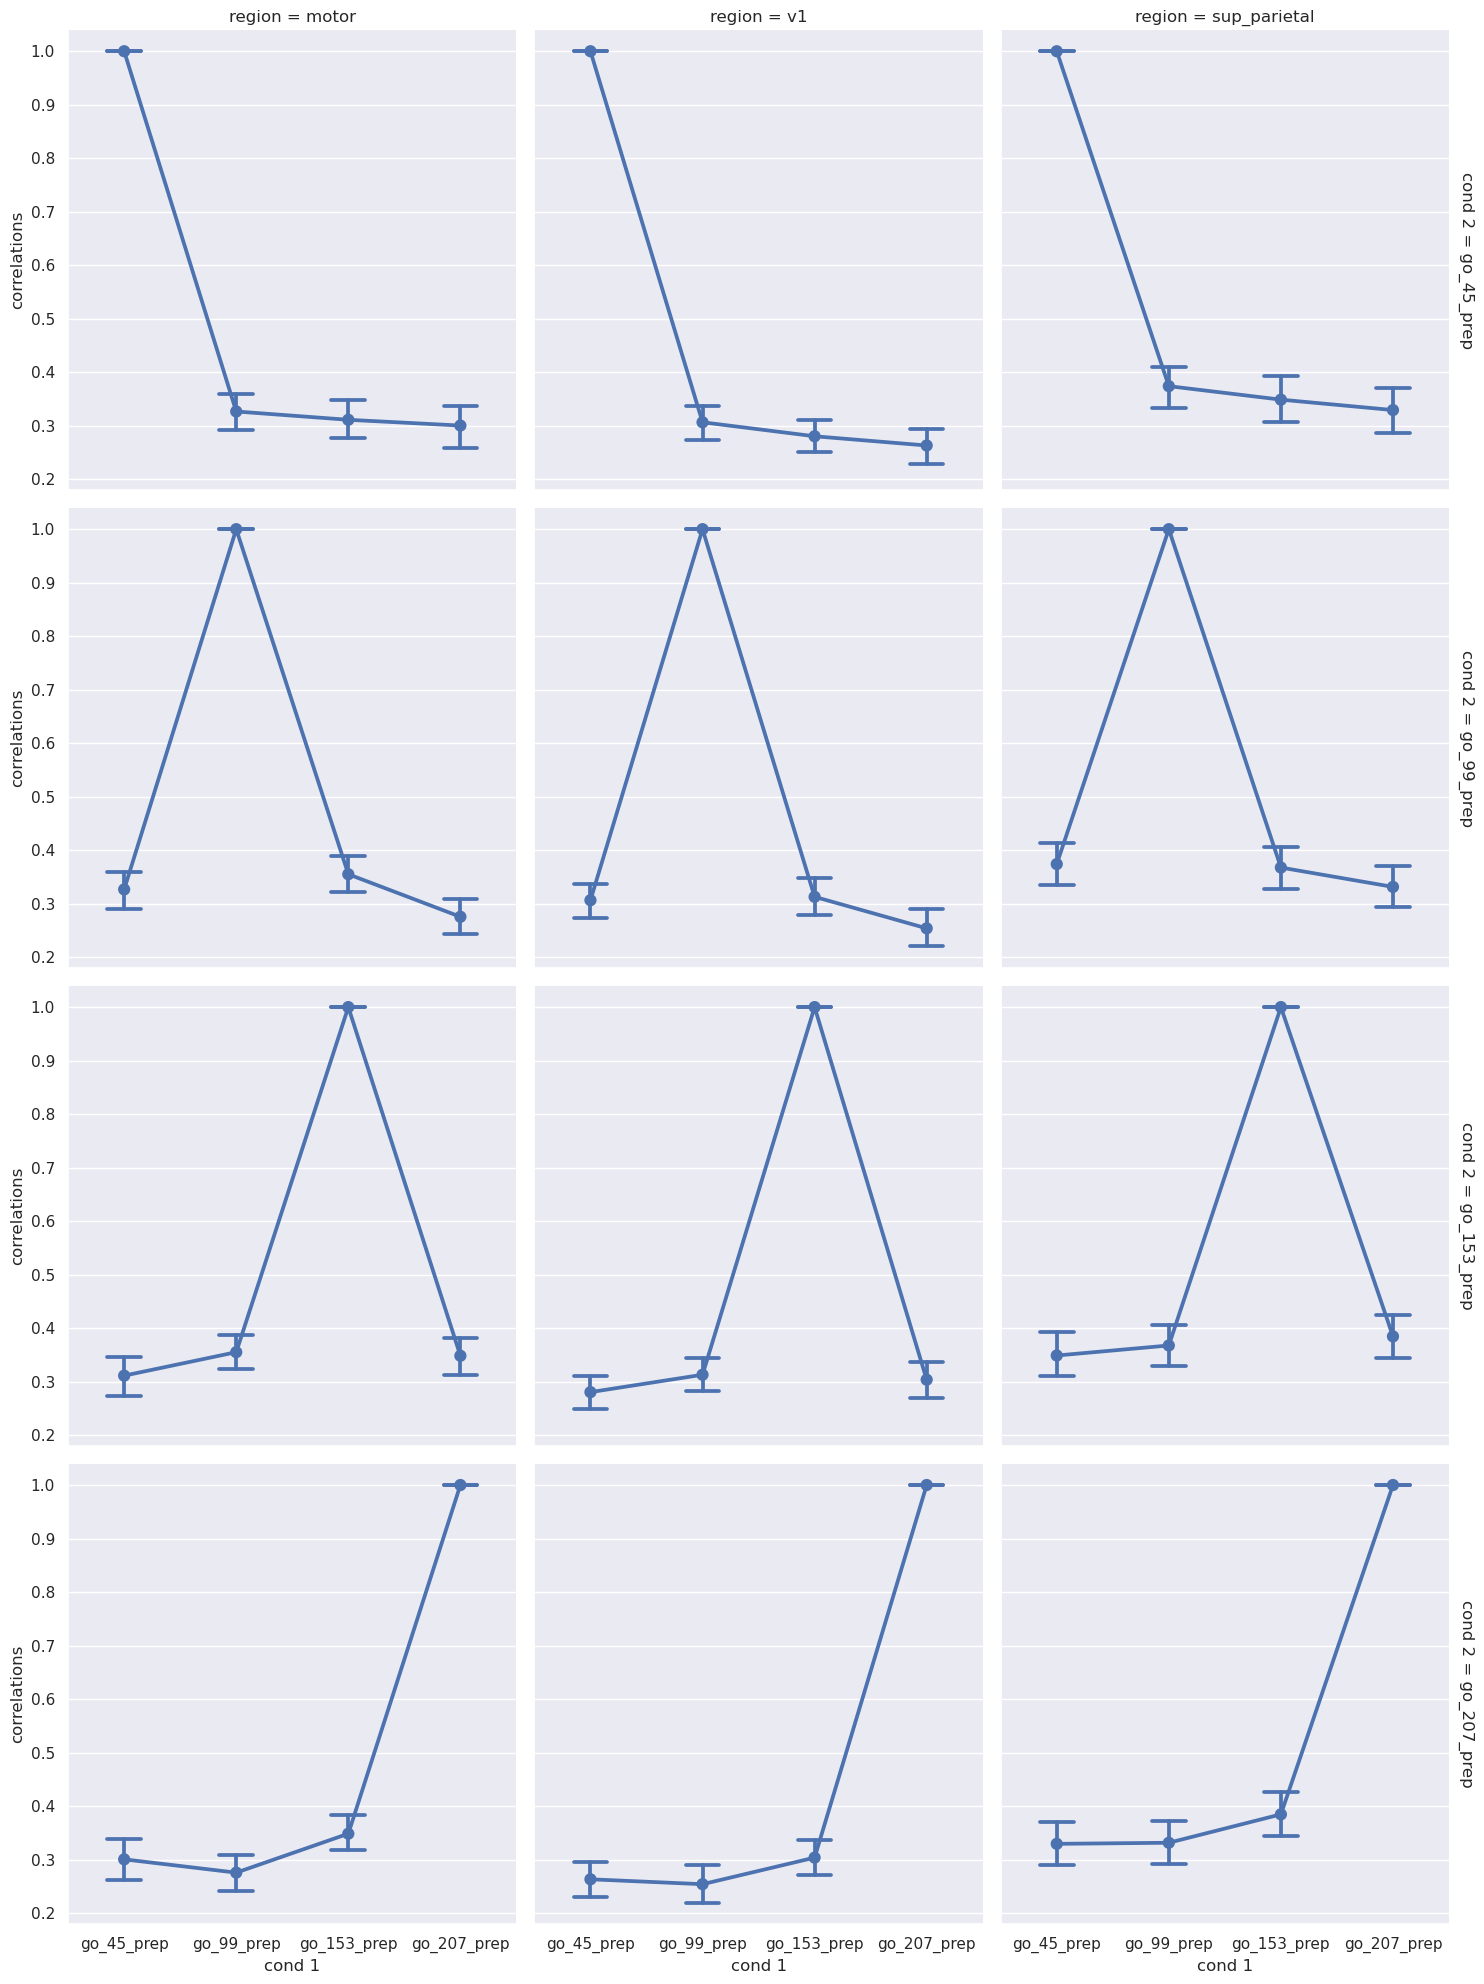

In [21]:
sns.set_context('poster') #Better font sizes
sns.set_theme()
g = sns.catplot(
    x = 'cond 1', col = 'region', y = 'correlations', row = 'cond 2',
    kind = 'point', capsize = 0.3, margin_titles = True,
    data = corr_df.loc[(() & (corr_df['cond 1'].str.contains('prep')) & (corr_df['cond 2'].str.contains('prep')) & 
    (corr_df['cond 1'].str.startswith('go')) & (corr_df['cond 2'].str.startswith('go')))],
)
# g.set_xticklabels(g.get_xticklabels(), rotation=45)

# plt.savefig('mvpa_outputs/plots/nogo_correlations.png', dpi = 600)

In [21]:
corr_df['corr_type'] = 'within'
corr_df_cross['corr_type'] = 'across'
comb_cross_within = pd.concat([corr_df, corr_df_cross]).reset_index(drop=True)
# comb_cross_within['cond 1'] = comb_cross_within['cond 1'] + ' ' + comb_cross_within['corr_type']


In [22]:
sns.set_context('poster') #Better font sizes
sns.set_theme()
g = sns.catplot(
    x = 'cond 1', col = 'region', y = 'correlations', row = 'cond 2', hue = 'corr_type',
    kind = 'point', capsize = 0.3, margin_titles = True,
    data = comb_cross_within.loc[((corr_df['cond 1'].str.contains('prep')) & (corr_df['cond 2'].str.contains('prep')) & 
    (corr_df['cond 1'].str.startswith('go')) & (corr_df['cond 2'].str.startswith('go')))],
)
# g.set_xticklabels(g.get_xticklabels(), rotation=45)

# plt.savefig('mvpa_outputs/plots/nogo_correlations.png', dpi = 600)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [24]:
comb_cross_within

,subject,block,cond 1,cond 2,correlations,region,type,corr_type
0,0,0,go_45_prep,go_45_prep,1.000000,motor,straight,within
1,0,0,go_45_prep,go_99_prep,0.905515,motor,straight,within
2,0,0,go_45_prep,go_153_prep,0.792991,motor,straight,within
3,0,0,go_45_prep,go_207_prep,0.520672,motor,straight,within
4,0,0,go_45_prep,nogo_45_prep,0.756018,motor,straight,within
...,...,...,...,...,...,...,...,...
264955,22,4,non_movement_207,movement_207,0.117021,sup_parietal,NaN,across
264956,22,4,non_movement_207,non_movement_45,0.154858,sup_parietal,NaN,across
264957,22,4,non_movement_207,non_movement_99,0.180476,sup_parietal,NaN,across
264958,22,4,non_movement_207,non_movement_153,0.488038,sup_parietal,NaN,across


In [ ]:
sns.set_context('poster') #Better font sizes
sns.set_theme()
g = sns.catplot(
    x = 'cond 1', col = 'region', y = 'correlations', row = 'cond 2',
    kind = 'point', capsize = 0.3, margin_titles = True,
    data = corr_df.loc[((corr_df['cond 1'].str.contains('prep')) & (corr_df['cond 2'].str.contains('prep')) & 
    (corr_df['cond 1'].str.startswith('go')) & (corr_df['cond 2'].str.startswith('go')))],
)
# g.set_xticklabels(g.get_xticklabels(), rotation=45)

# plt.savefig('mvpa_outputs/plots/nogo_correlations.png', dpi = 600)

# Computing correlations between odd and even blocks 
(i.e. odd for straight correlated with even for straight)

In [8]:
def extract_corr_oddevenmeans_sub(paths, region = 'motor', nsub = 23):
    #parallelize extracting roi signals. This is the main bottleneck in computation since it requires reading and writing
    pool = multiprocessing.Pool()
    signal_all_sub = pool.starmap(
            extract_roi_signals_juelich,
            zip(paths, 
            itertools.repeat(list(event_stat_map.keys())), 
            itertools.repeat(region), 
            itertools.repeat(masks), 
            itertools.repeat(dataset_juelich)
            )
        )



    odd = []
    for sub in range(23):
        odd.append(signal_all_sub[(sub)*5:(sub+1)*5:2])

    even = []
    for sub in range(23):
        even.append(signal_all_sub[(sub)*5+1:(sub+1)*5:2])

    odd_means = [np.mean(x, axis = 0) for x in odd]
    even_means = [np.mean(x, axis = 0) for x in even]

    corr_maps = np.array([
        [
            [ stat.pearsonr(x, y)[0] for x in odd_means[sub][1::2]]
            for y in even_means[sub][1::2]
        ]
        for sub in range(23)
    ])

    return corr_maps

In [9]:
straight_corr_dict = {}
for key in masks.keys():
    straight_corr_dict[key] = extract_corr_oddevenmeans_sub(sub_straight_paths, region=key)
    print('Mask done: ', key)

rotate_corr_dict = {}
for key in masks.keys():
    rotate_corr_dict[key] = extract_corr_oddevenmeans_sub(sub_rotate_paths, region=key)
    print('Mask done: ', key)

Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  somatosensory
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  somatosensory


In [18]:
#Dictionaries to dataframes for easy plotting and stats
def create_corr_dict(typ = 'straight', corr_dict = straight_corr_dict):
    temp_df = []
    for region in masks.keys():
        corr_df = pd.DataFrame({
            'subject': np.repeat(np.arange(23), 16*16),
            # 'block': np.tile(np.repeat(np.arange(5), 16*16), 23),
            'cond 1': np.tile(np.repeat(list(event_stat_map.keys())[1::2], 16), 23),
            'cond 2': np.tile(list(event_stat_map.keys())[1::2], 16*23),
            'correlations': np.ravel(corr_dict[region])
        })
        corr_df['region'] = region
        corr_df['type'] = typ
        temp_df.append(corr_df)
    return pd.concat(temp_df)


corr_df = pd.concat([create_corr_dict('straight', straight_corr_dict), create_corr_dict('rotate', rotate_corr_dict)])

In [24]:
corr_df.to_csv('mvpa_outputs/correlation_csvs/oddevenmean_correlations.csv', index=False)

/work/pi_rcowell_umass_edu/tsavalia/scratch/miniconda3/envs/vma_fmri/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


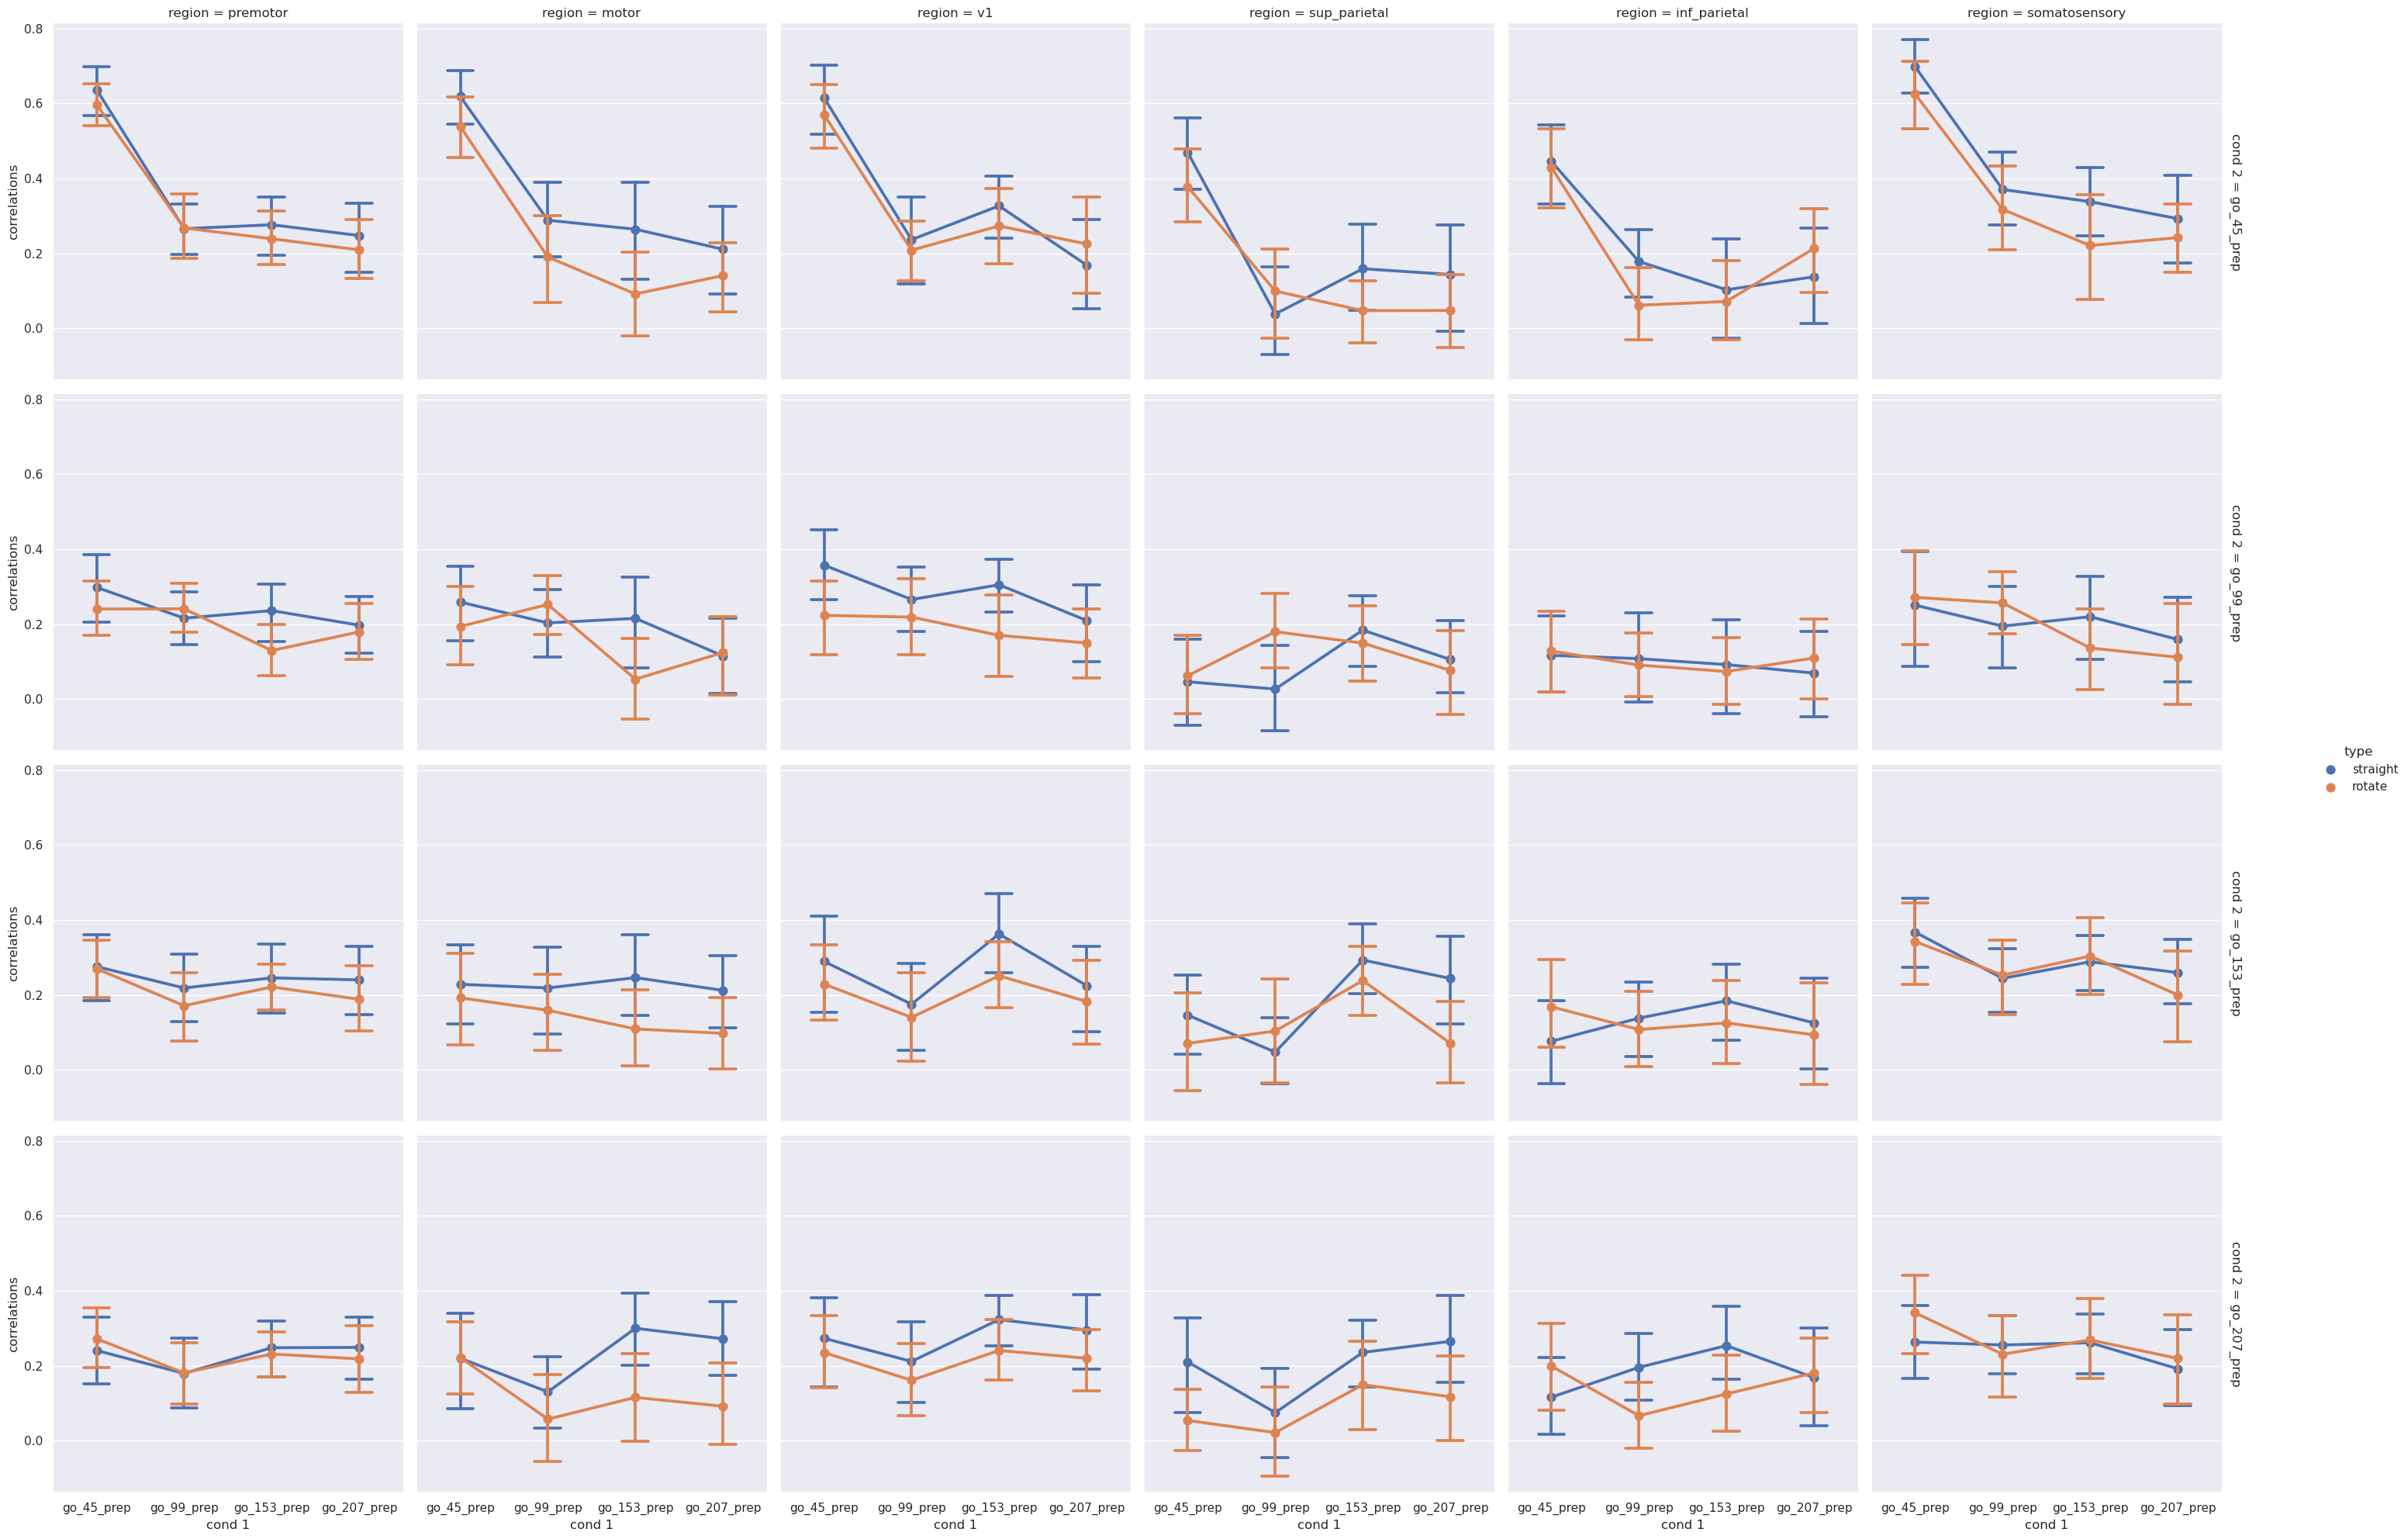

In [34]:
corr_df = pd.read_csv('mvpa_outputs/correlation_csvs/oddevenmean_correlations.csv')
sns.set_context('poster') #Better font sizes
sns.set_theme()
g = sns.catplot(
    x = 'cond 1', hue = 'type', col = 'region', y = 'correlations', row = 'cond 2',
    kind = 'point', capsize = 0.3, margin_titles = True,
    data = corr_df.loc[((corr_df['cond 1'].str.contains('prep')) & (corr_df['cond 2'].str.contains('prep')) & 
    (corr_df['cond 1'].str.startswith('go')) & (corr_df['cond 2'].str.startswith('go')))],
)
# g.set_xticklabels(g.get_xticklabels(), rotation=45)

# plt.savefig('mvpa_outputs/plots/nogo_correlations_oddevenmeans.png', dpi = 600)

/work/pi_rcowell_umass_edu/tsavalia/scratch/miniconda3/envs/vma_fmri/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


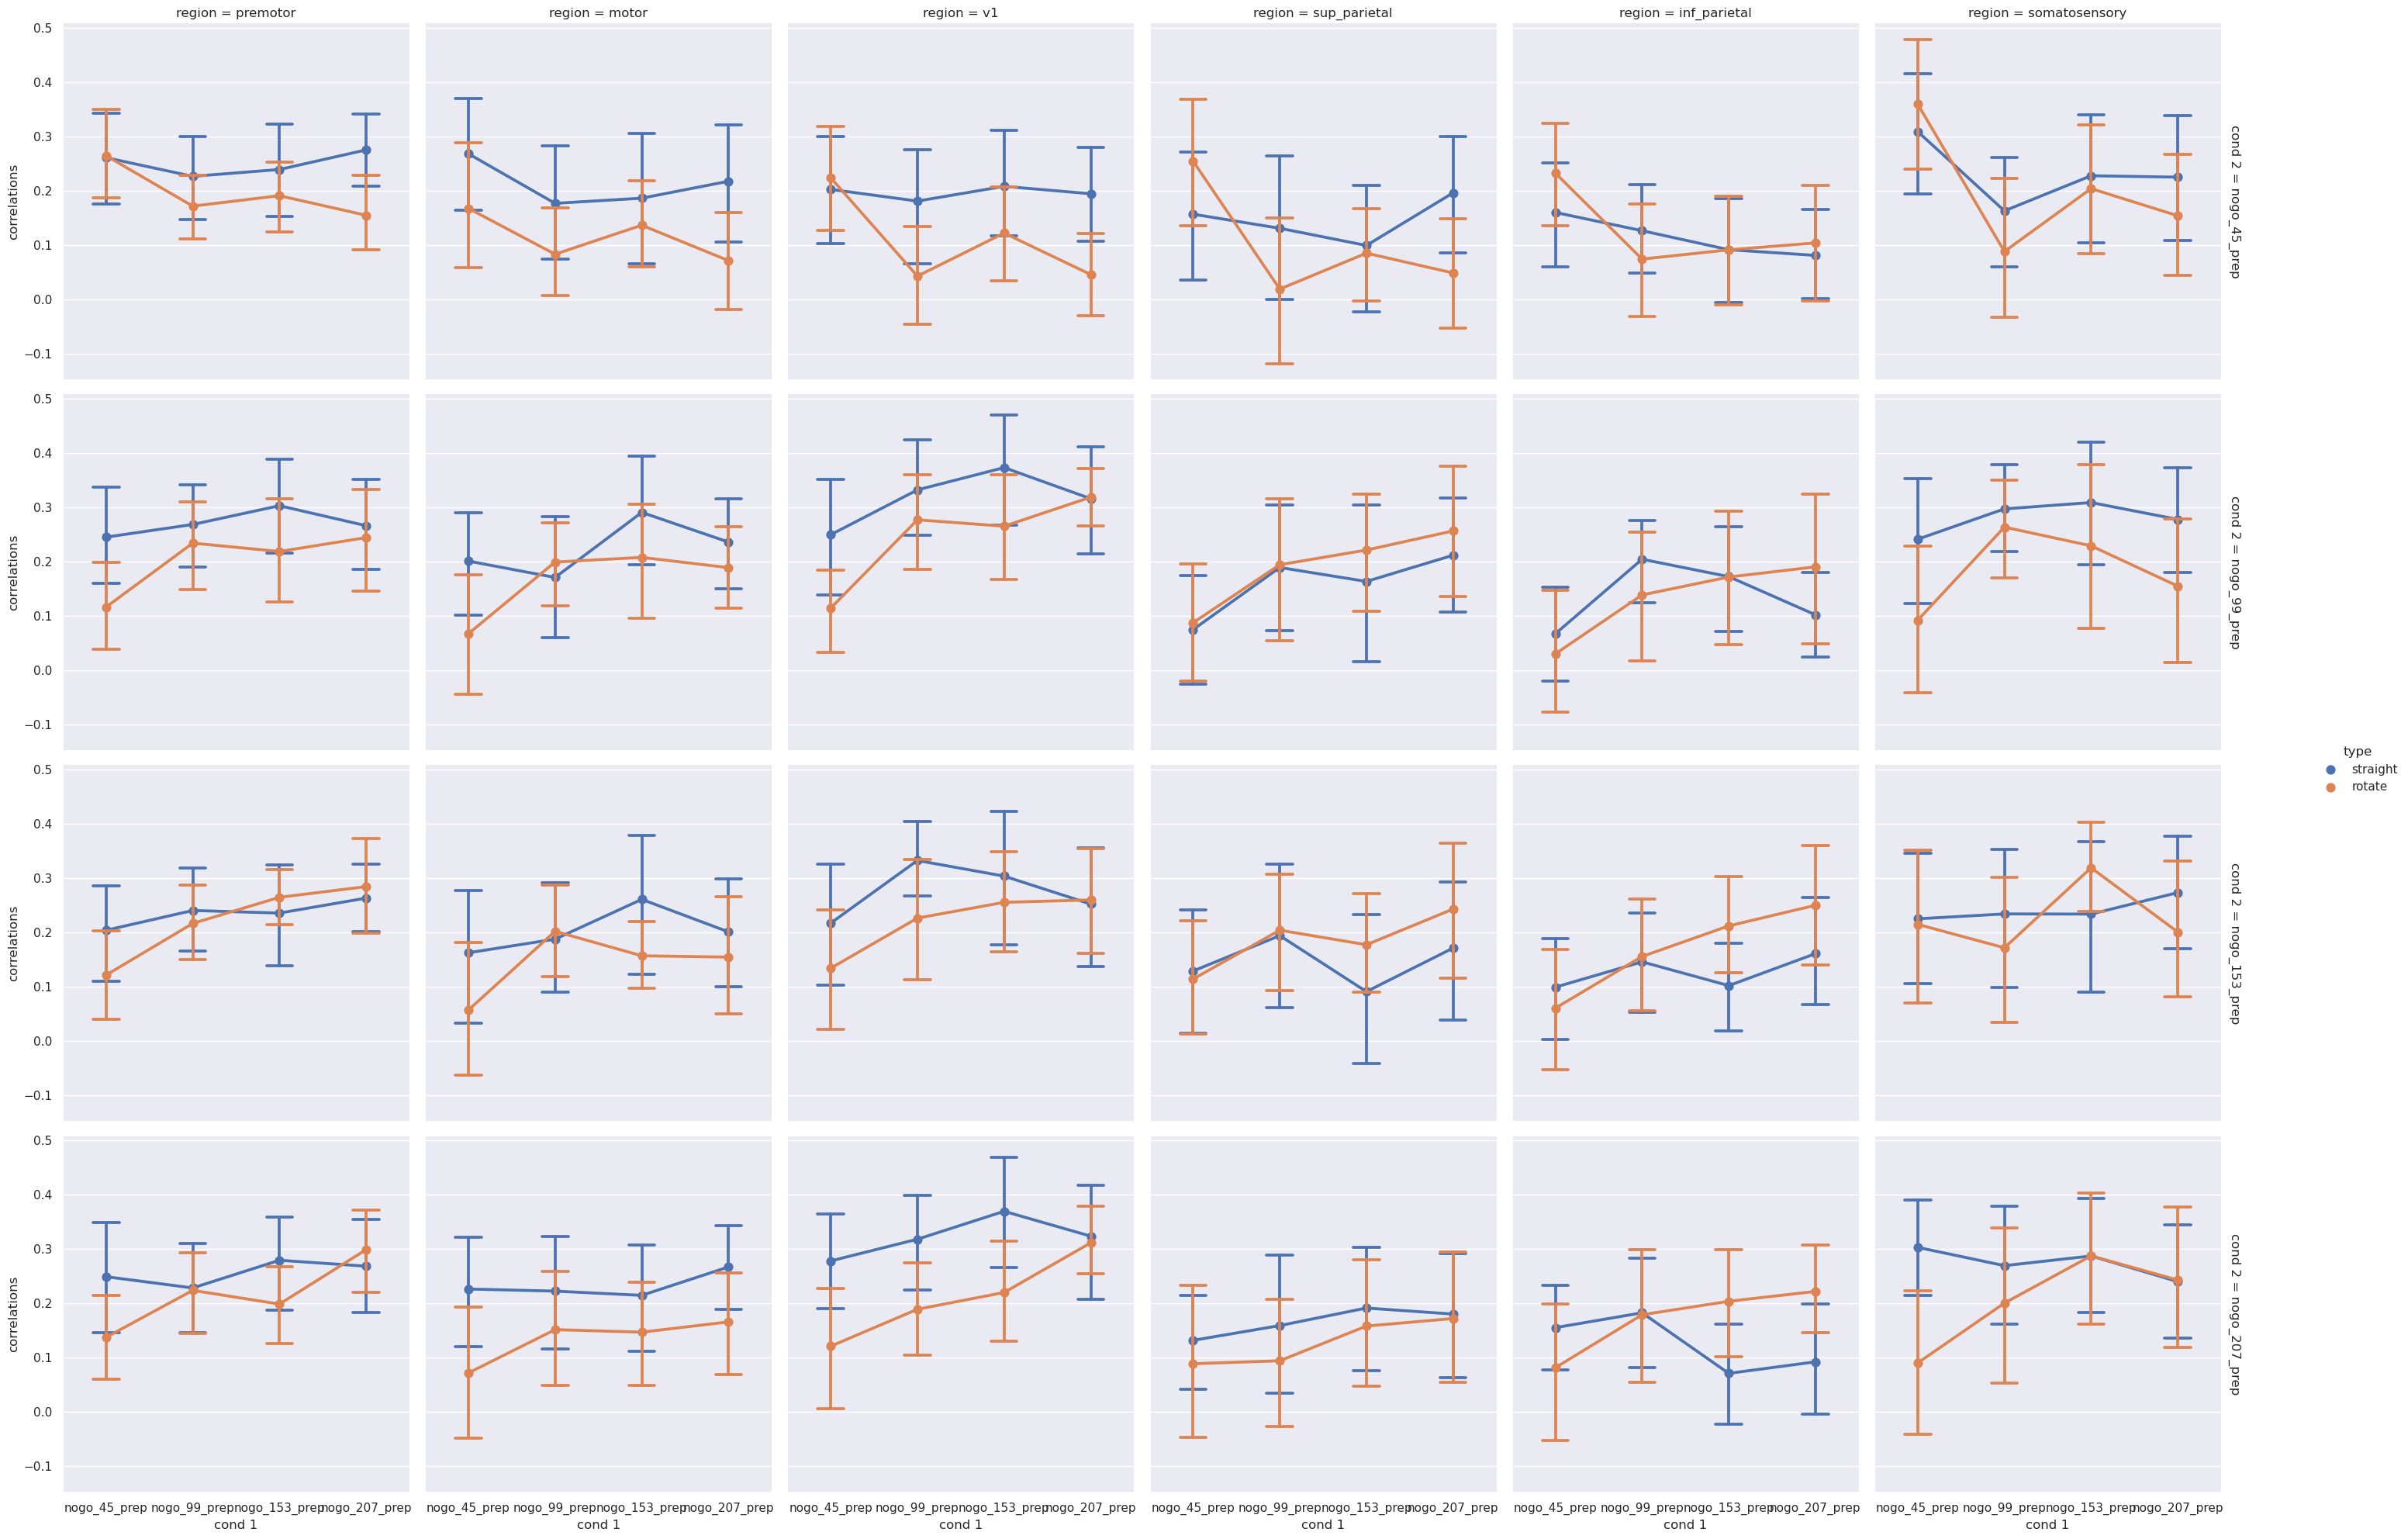

In [35]:
corr_df = pd.read_csv('mvpa_outputs/correlation_csvs/oddevenmean_correlations.csv')
sns.set_context('poster') #Better font sizes
sns.set_theme()
g = sns.catplot(
    x = 'cond 1', hue = 'type', col = 'region', y = 'correlations', row = 'cond 2',
    kind = 'point', capsize = 0.3, margin_titles = True,
    data = corr_df.loc[((corr_df['cond 1'].str.contains('prep')) & (corr_df['cond 2'].str.contains('prep')) & 
    (corr_df['cond 1'].str.startswith('nogo')) & (corr_df['cond 2'].str.startswith('nogo')))],
)
# g.set_xticklabels(g.get_xticklabels(), rotation=45)

# plt.savefig('mvpa_outputs/plots/nogo_correlations_oddevenmeans.png', dpi = 600)

/work/pi_rcowell_umass_edu/tsavalia/scratch/miniconda3/envs/vma_fmri/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


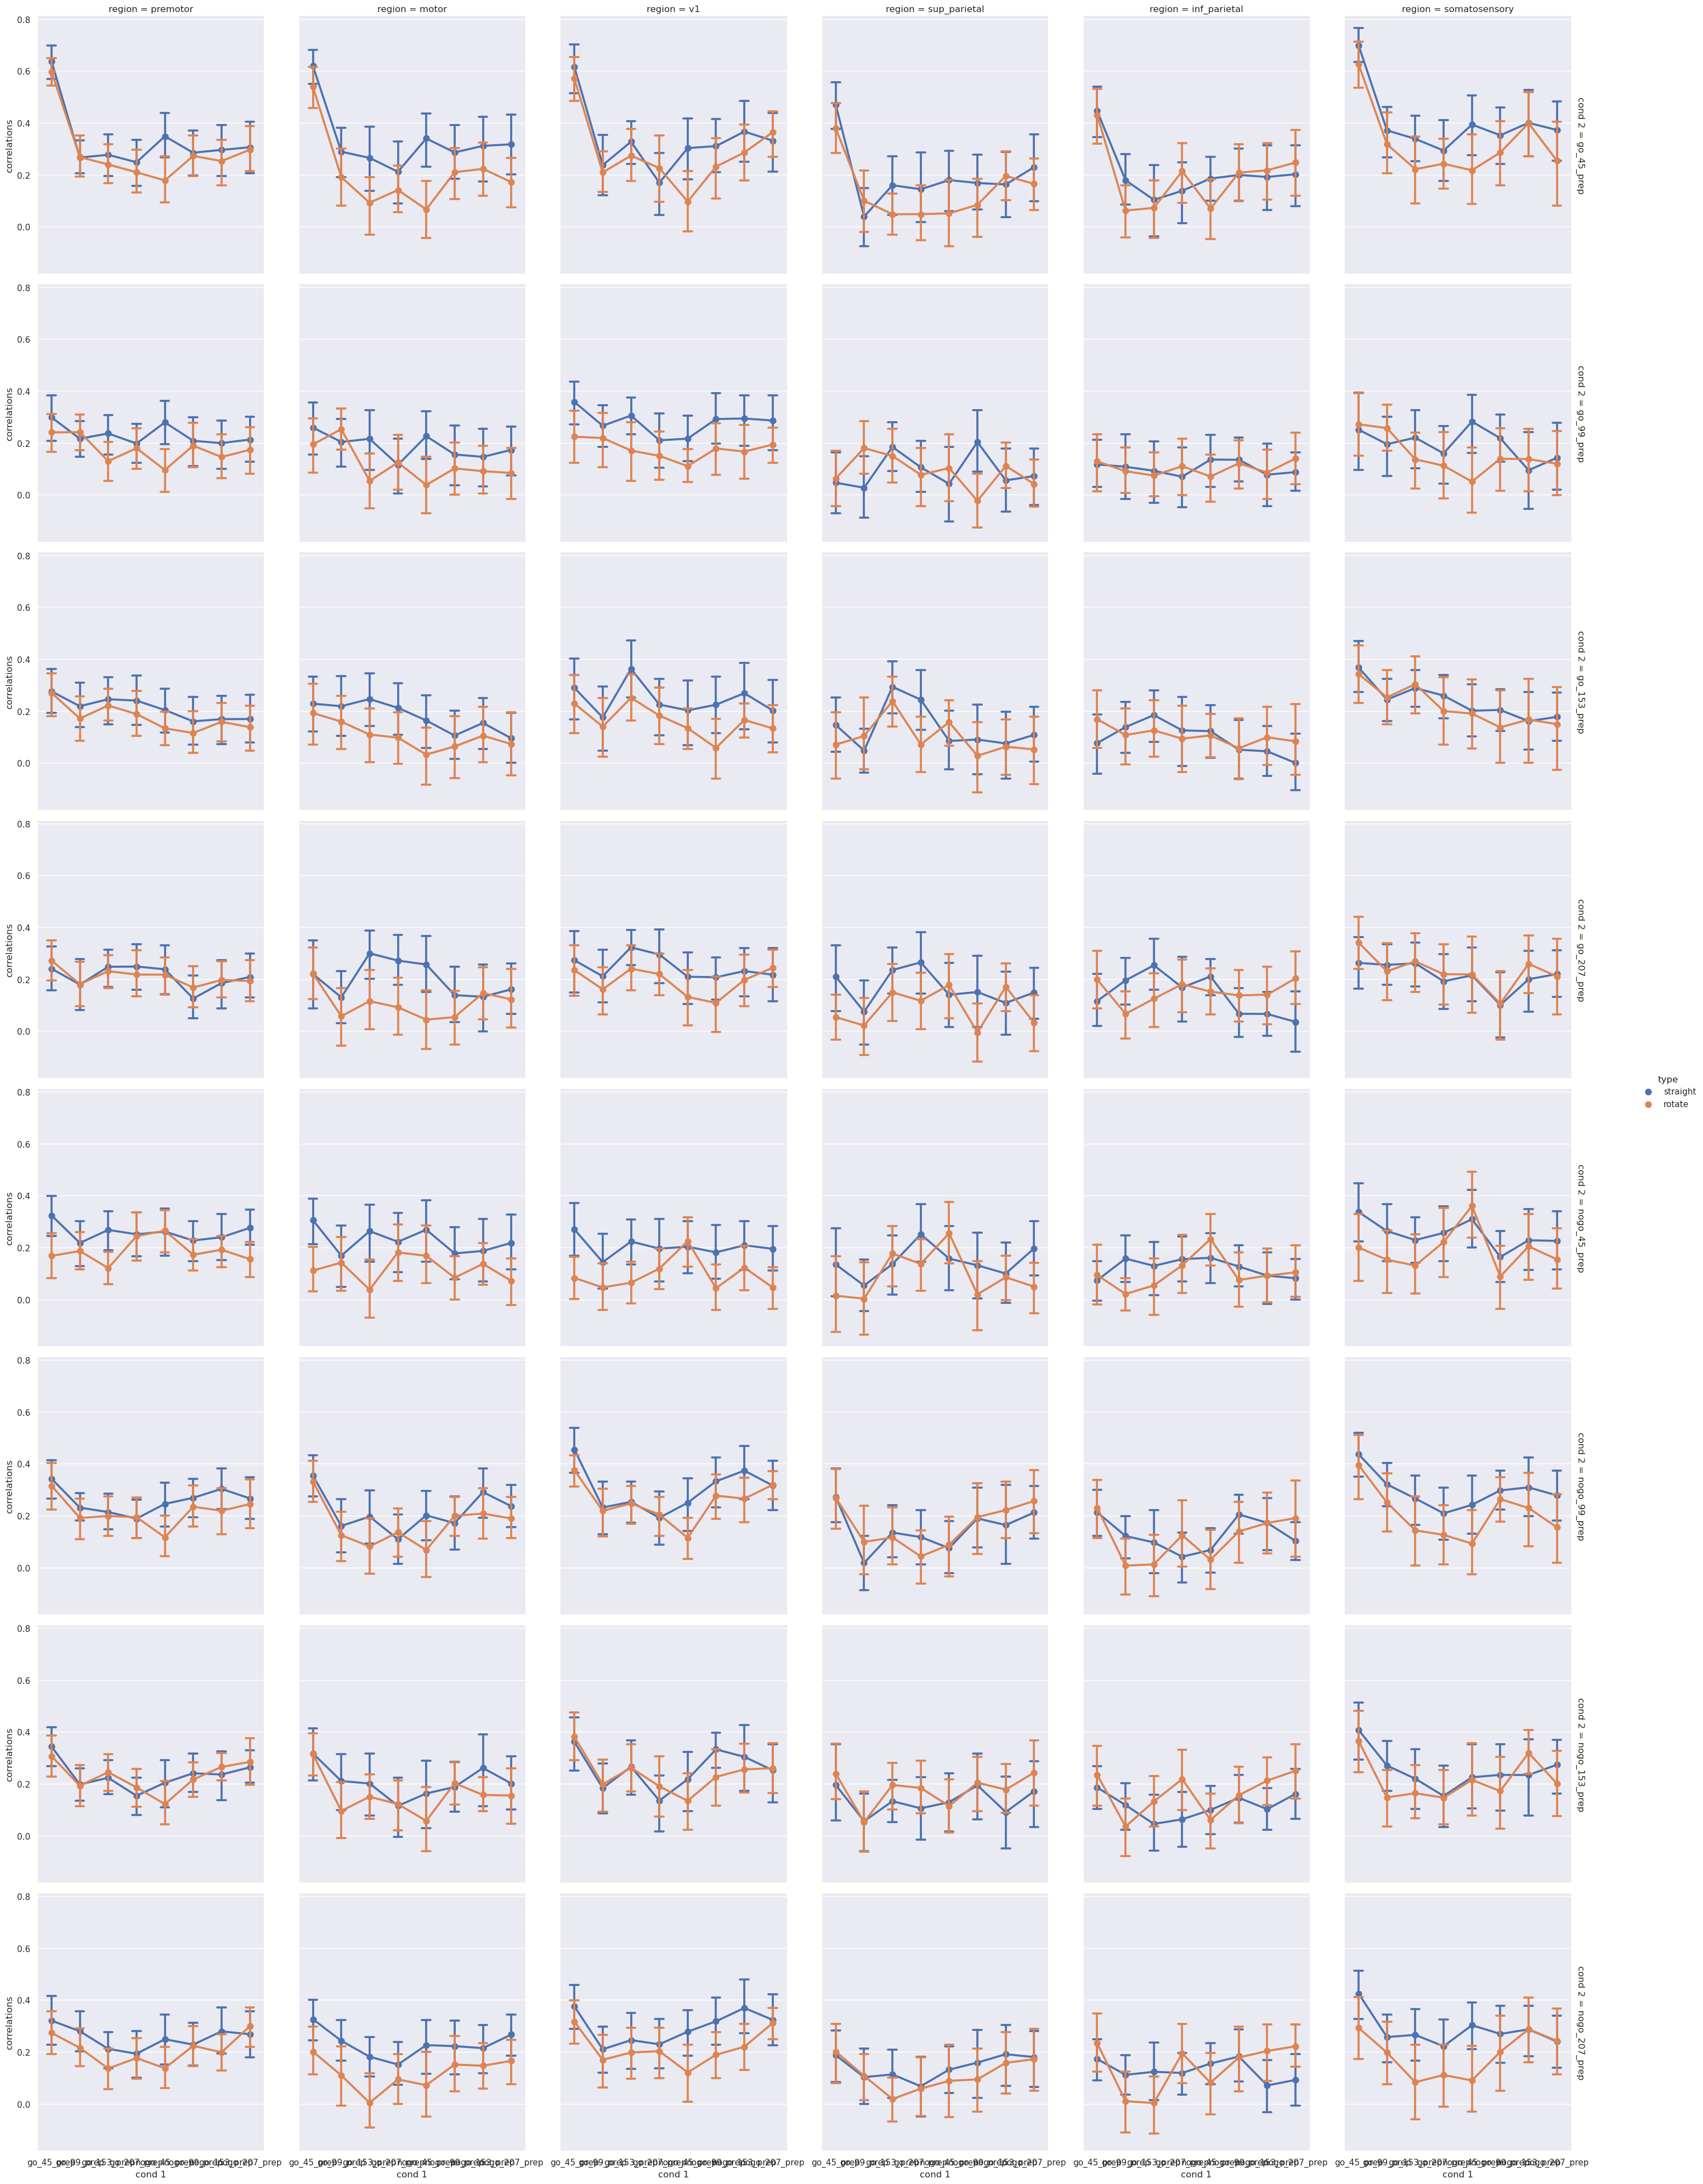

In [41]:
corr_df = pd.read_csv('mvpa_outputs/correlation_csvs/oddevenmean_correlations.csv')
sns.set_context('poster') #Better font sizes
sns.set_theme()
g = sns.catplot(
    x = 'cond 1', hue = 'type', col = 'region', y = 'correlations', row = 'cond 2',
    kind = 'point', capsize = 0.3, margin_titles = True,
    data = corr_df.loc[((corr_df['cond 1'].str.contains('prep')) & (corr_df['cond 2'].str.contains('prep')))]
    
)
# g.set_xticklabels(g.get_xticklabels(), rotation=45)

# plt.savefig('mvpa_outputs/plots/nogo_correlations_oddevenmeans.png', dpi = 600)

Self vs other: Is self more reliable than the other?

/work/pi_rcowell_umass_edu/tsavalia/scratch/miniconda3/envs/vma_fmri/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


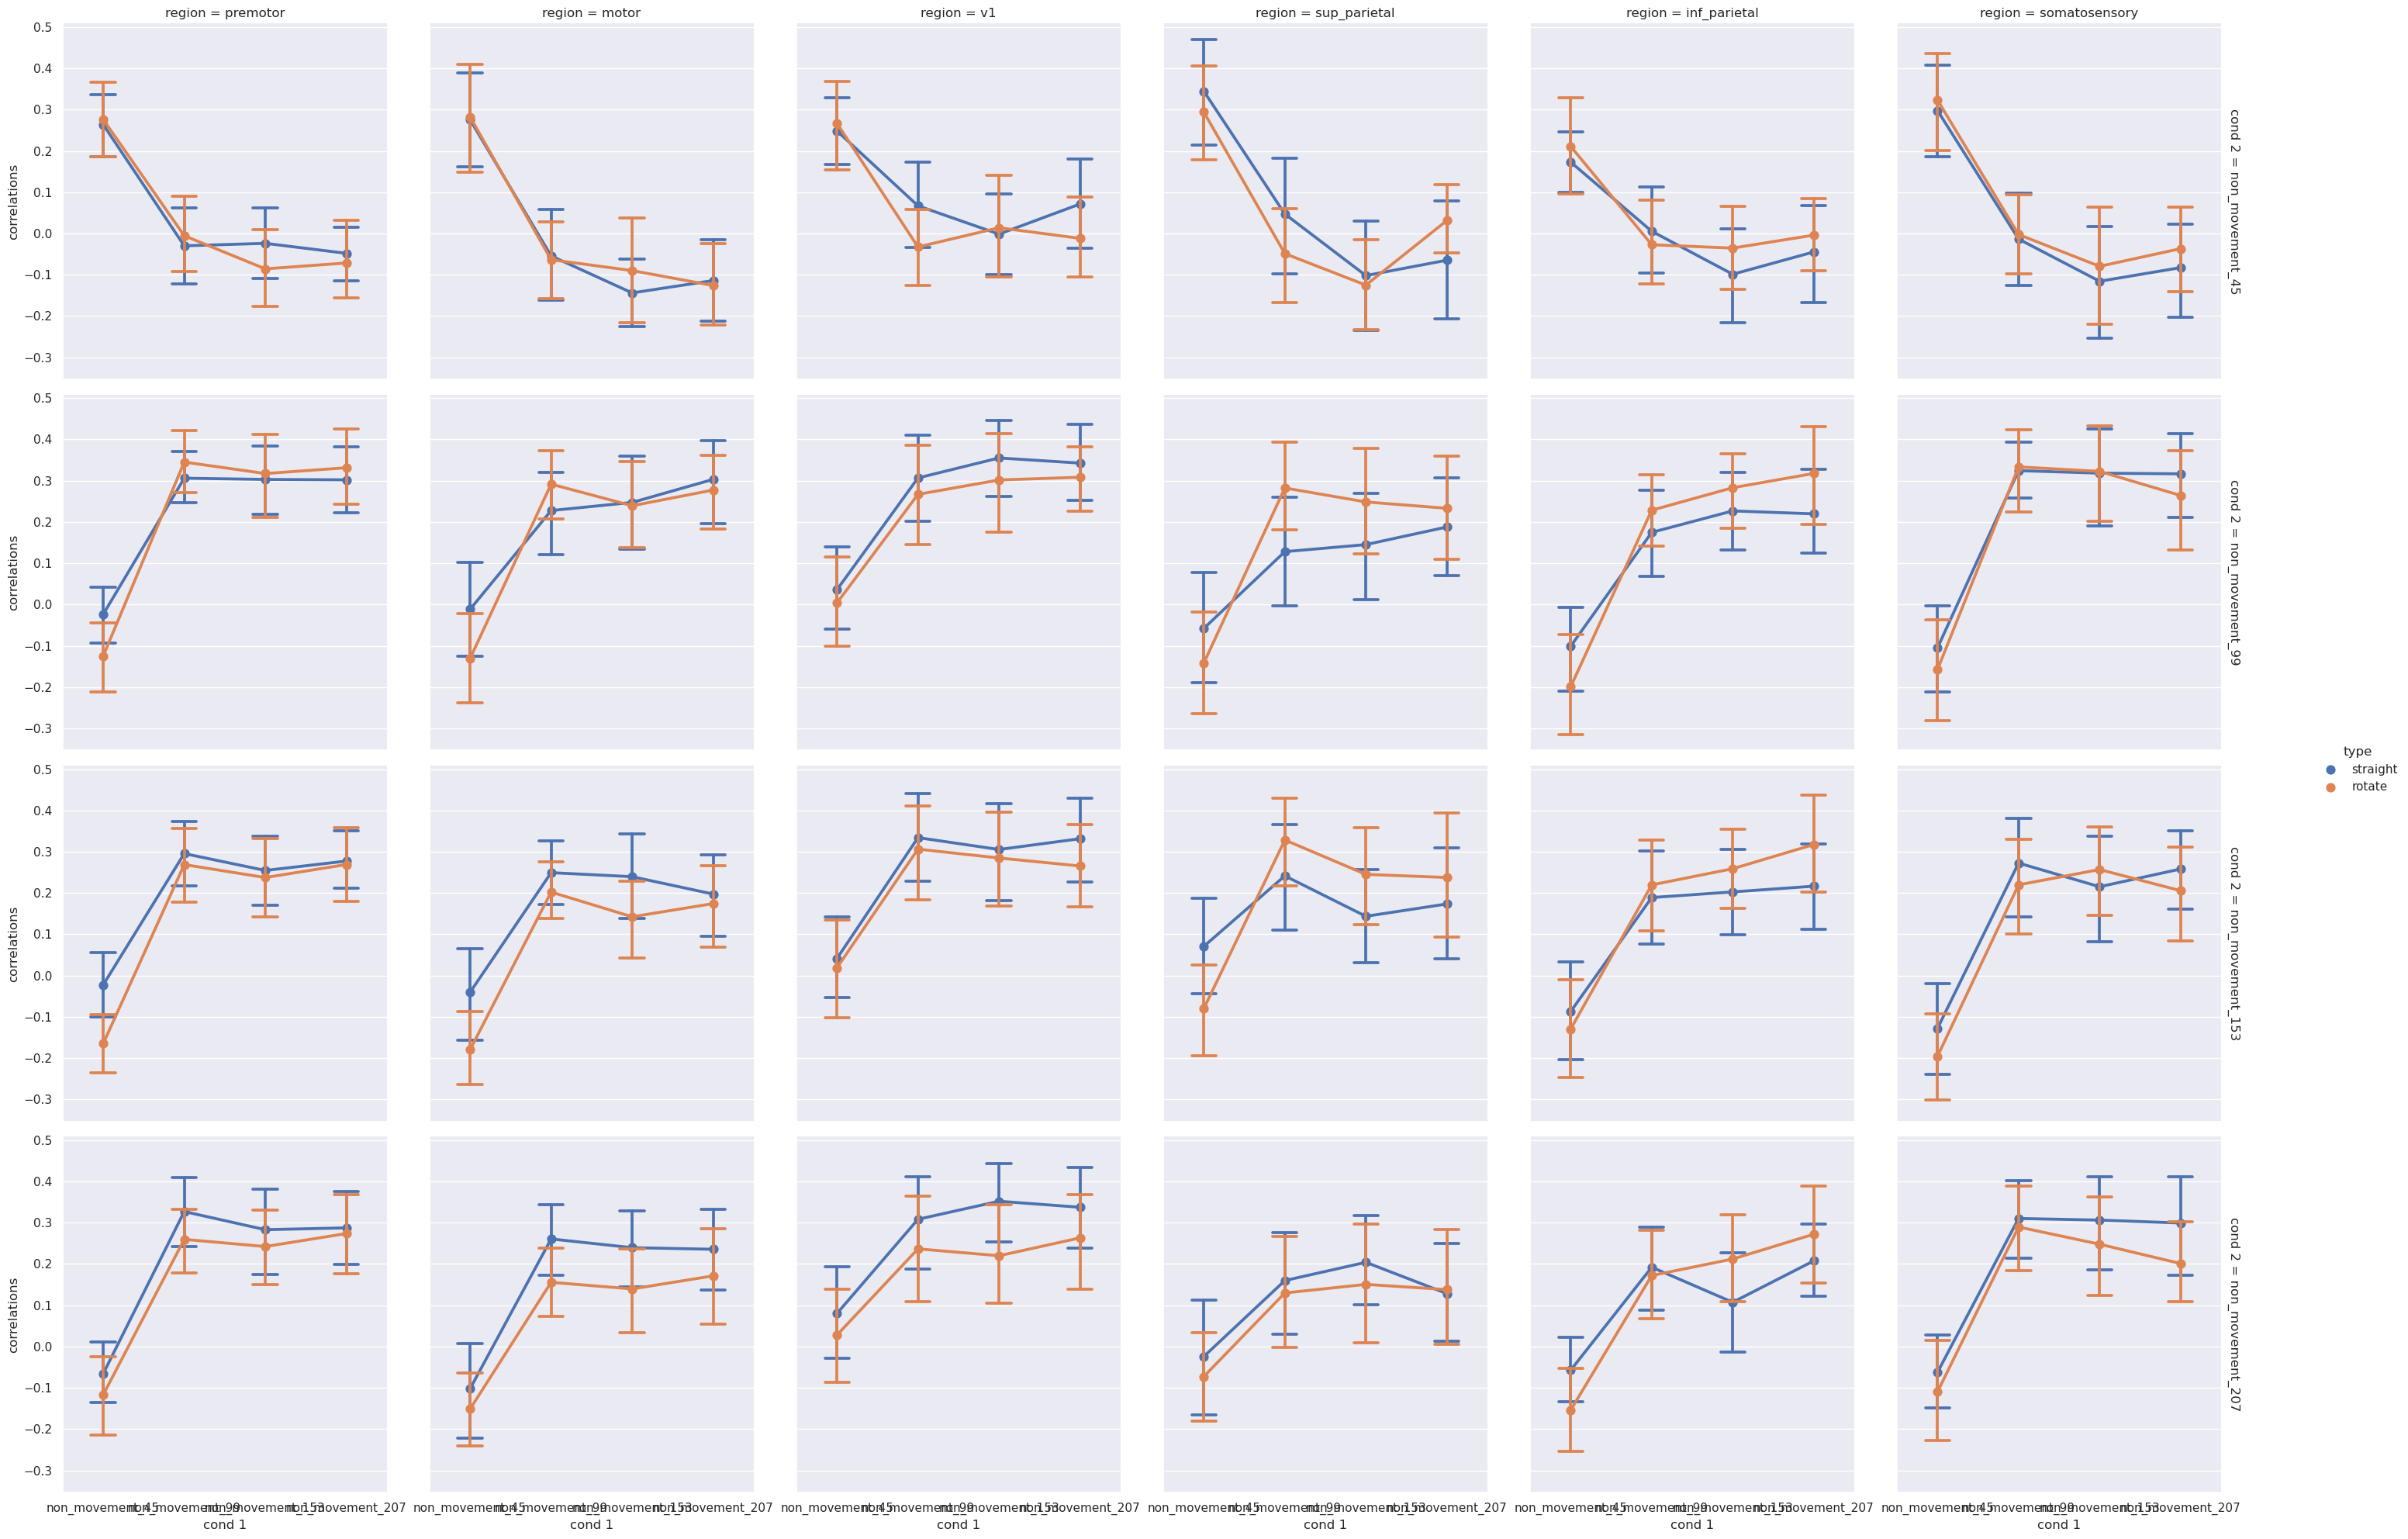

In [42]:
sns.set_context('poster') #Better font sizes
sns.set_theme()
g = sns.catplot(
    x = 'cond 1', hue = 'type', col = 'region', y = 'correlations', row = 'cond 2',
    kind = 'point', capsize = 0.3, margin_titles = True,
    data = corr_df.loc[((corr_df['cond 1'].str.startswith('non_movement')) & (corr_df['cond 2'].str.startswith('non_movement')))],
)
# g.axes[0][0].set_xticklabels(g.get_xticklabels(), rotation=45)

# plt.savefig('mvpa_outputs/plots/nogo_correlations_oddevenmeans.png', dpi = 600)

In [114]:
# Big anova: straight, rotate x angle x region
# In non movement, is target still on screen?
# Separate hemispheres.

# LOO Cross validation Correlations

In [9]:
def extract_corr_loonmeans_sub(paths, region = 'motor', nsub = 23):
    #parallelize extracting roi signals. This is the main bottleneck in computation since it requires reading and writing
    # pool = multiprocessing.Pool()
    signal_all_sub = [
            extract_roi_signals_juelich,
            zip(paths, 
            itertools.repeat(list(event_stat_map.keys())), 
            itertools.repeat(region), 
            itertools.repeat(masks), 
            itertools.repeat(dataset_juelich)
            )
    ]
# 
#     corr_maps = []
#     for sub in range(nsub):
#         sub_signal = signal_all_sub[sub*5:(sub+1)*5]

#         for i in range(5):
#             a = np.array(sub_signal)[i][1::2]
#             b = np.mean(np.delete(sub_signal, i, axis = 0), axis = 0)[1::2]
#             for x in a:
#                 for y in b:
#                     corr_maps.append()
#     corr_maps = [
#         [
#             [
#                 [stat.pearsonr(x, y)[0] for x in signal_all_sub]
#             ]
#         ]
#     ]

    # four = []
    # one = []
    # for sub in range(23):
    #     four.append(signal_all_sub[(sub)*5:(sub+1)*5+4:])
    #     one.append(signal_all_sub[(sub)*5+4:(sub+1)*5])

    # even = []
    # for sub in range(23):
    #     even.append(signal_all_sub[(sub)*5+1:(sub+1)*5:2])

    # odd_means = [np.mean(x, axis = 0) for x in odd]
    # even_means = [np.mean(x, axis = 0) for x in even]

    # corr_maps = np.array([
    #     [
    #         [ stat.pearsonr(x, y)[0] for x in odd_means[sub][1::2]]
    #         for y in even_means[sub][1::2]
    #     ]
    #     for sub in range(23)
    # ])

    return signal_all_sub

In [36]:
conditions_of_interest = {}
for condition in event_stat_map.keys():
    if condition.endswith('prep'):
        conditions_of_interest[condition] = event_stat_map[condition]

In [40]:
region = 'v1'
mask_image = image.new_img_like(dataset_juelich.maps, image.get_data(dataset_juelich.maps) == np.where(np.array(dataset_juelich.labels) == masks[region])[0][0])


In [42]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=4)

import nilearn.decoding

# The radius is the one of the Searchlight sphere that will scan the volume
searchlight = nilearn.decoding.SearchLight(
    mask_image,
    radius=5.6,
    n_jobs=2,
    verbose=1,
    cv=cv,
)

In [ ]:
fmri_image = 

In [60]:
# straight_roi_sigmals = [extract_roi_signals_juelich(path, conditions_of_interest, 'motor', masks, dataset_juelich) for path in sub_straight_paths]
straight_roi_signals = roi_sigmals
rotated_roi_sigmals = [extract_roi_signals_juelich(path, conditions_of_interest, 'motor', masks, dataset_juelich) for path in sub_rotate_paths]

In [238]:
len(straight_roi_signals)
nsub = 15

In [244]:
block1_signals = straight_roi_signals[::5]